In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Q
2. In this question you will implement and compare the following different KNN variants (see: https://youtu.be/C9HQLyXwEw0?t=3382)
1. LSH (1 marks)
2. KD-tree (1 marks)
3. Naive version of KNN (0.5 marks)

Vary dataset size $N$, number of dimensions $D$ to do training and testing time and memory comparison for finding $K$ nearest neighbours. (1 mark)

Now, in a 2d randomly generated dataset visually show how many of the $K$ closest neighbors appx. $K$ NN methods miss out due to their approximate nature. 

Also show the partitions in the 2d space. (0.5 marks)


# Q2, part1
**Explaining how LSH,KD-trees and Naive CNN vary with dataset size and dimension in train/test size and memory usage**

     Method  Dataset Size  Dimensions  Train Time (s)  Test Time (s)  \
0       LSH           100           2        0.072436       0.003984   
1   KD-Tree           100           2        0.001139       0.000485   
2     Naive           100           2        0.002218       0.000609   
3       LSH           100           5        0.023453       0.090322   
4   KD-Tree           100           5        0.000601       0.000294   
5     Naive           100           5        0.000835       0.000439   
6       LSH           100          10        0.021920       0.124025   
7   KD-Tree           100          10        0.000540       0.000343   
8     Naive           100          10        0.000997       0.000427   
9       LSH           100          20        0.029603       0.119501   
10  KD-Tree           100          20        0.001208       0.000878   
11    Naive           100          20        0.000960       0.000703   
12      LSH           500           2        0.077693       0.15

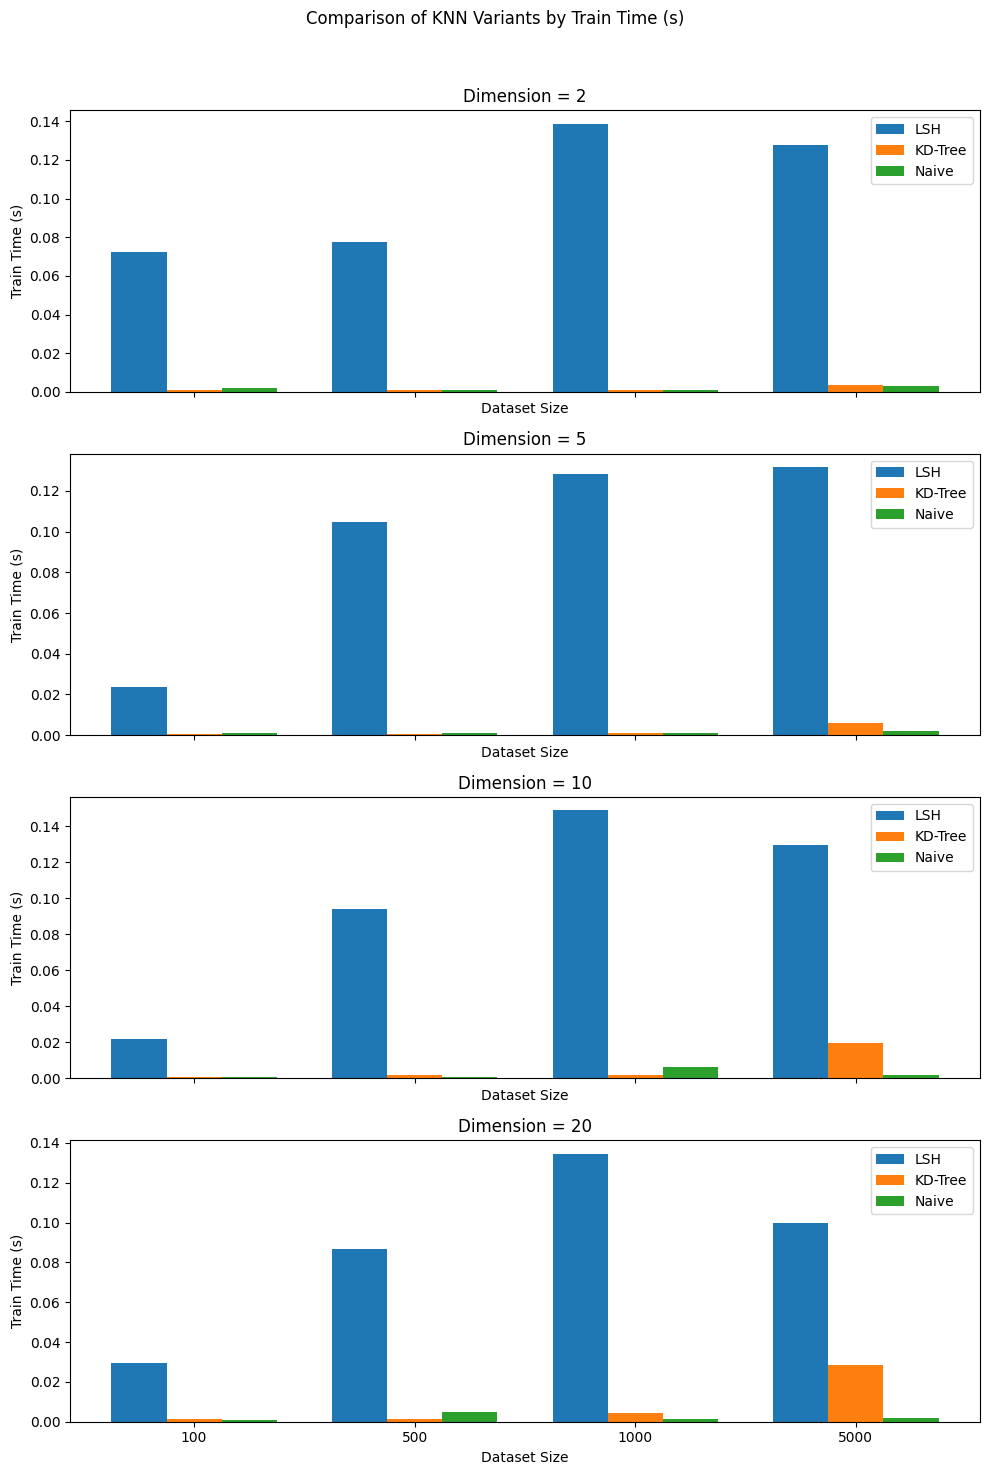

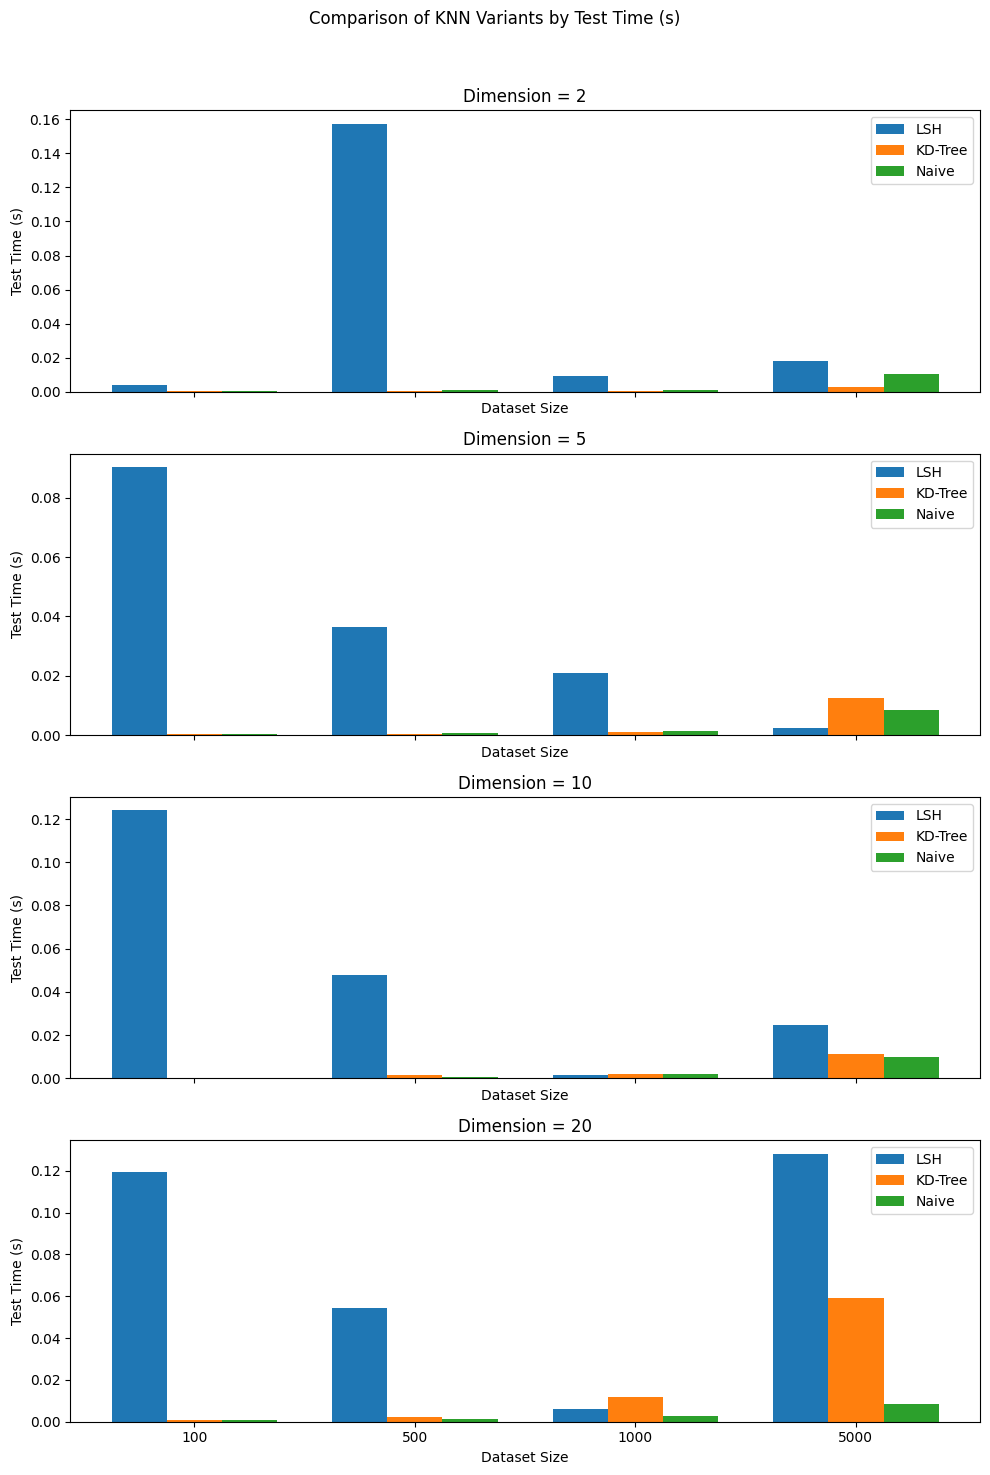

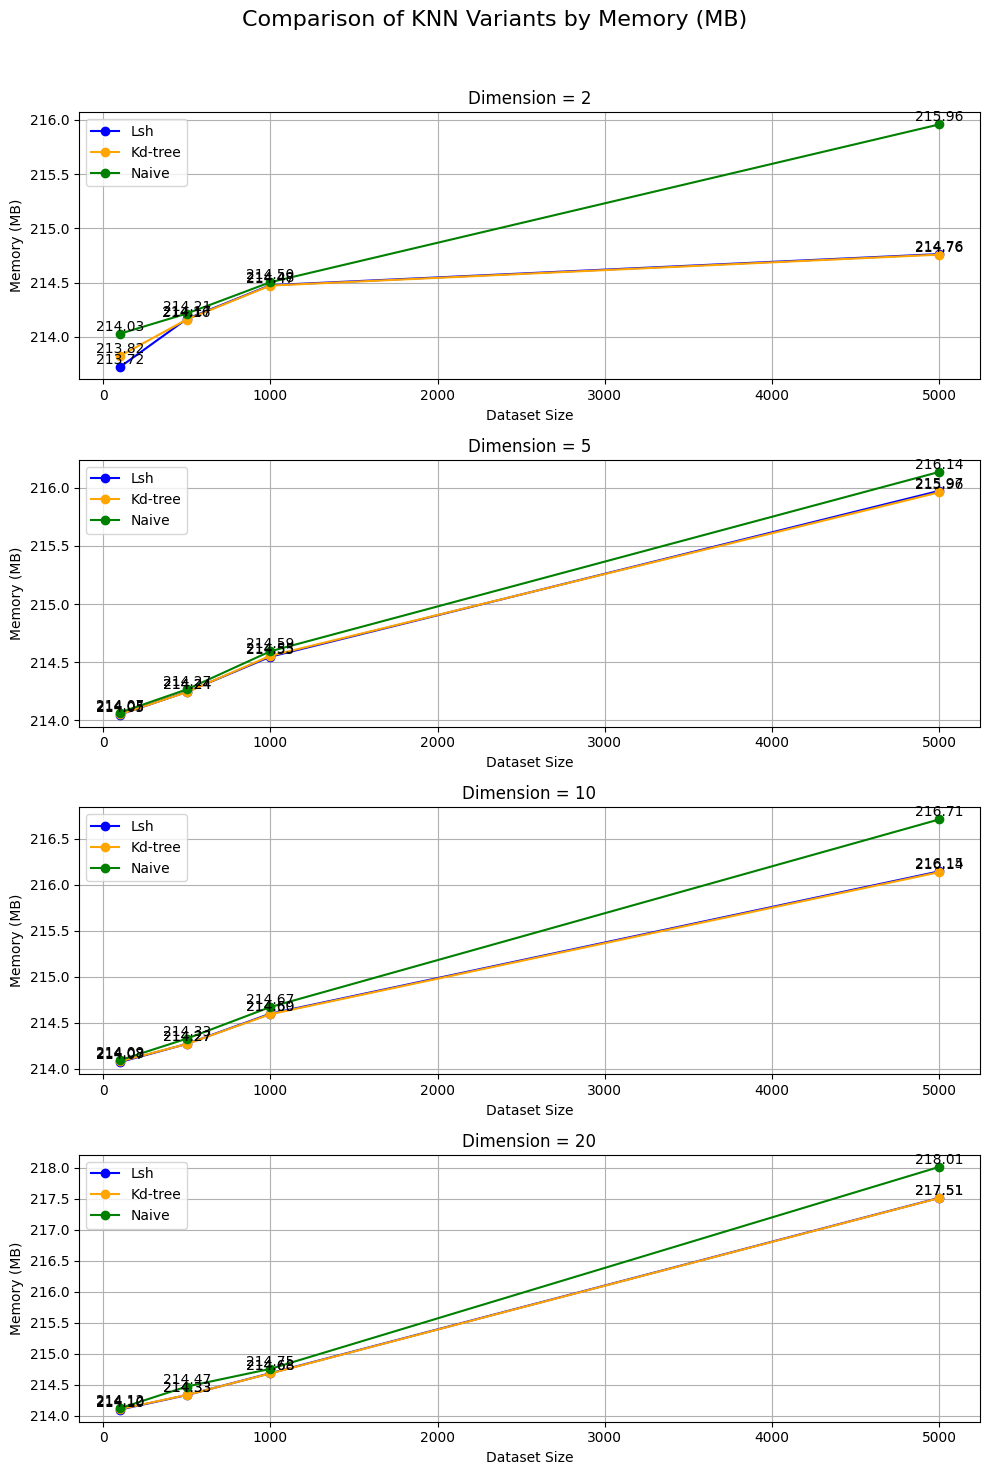

In [1]:
import numpy as np
import time
from memory_profiler import memory_usage
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.metrics import pairwise_distances

# 1. Implement Approximate KNN using LSH
def approximate_knn(X_train, X_test, K,projections=5):
    np.random.seed(0)
    R = np.random.randn(X_train.shape[1], projections)
    X_train_proj = X_train @ R
    X_test_proj = X_test @ R
    nn = NearestNeighbors(n_neighbors=K, algorithm='brute').fit(X_train_proj)
    distances, indices = nn.kneighbors(X_test_proj)
    return indices, distances

# 2. Implement KD-tree KNN
def kd_tree_knn(X_train, X_test, K):
    kd_tree = KDTree(X_train, leaf_size=30)
    distances, indices = kd_tree.query(X_test, k=K)
    return indices, distances

# 3. Implement Naive KNN
def naive_knn(X_train, X_test, K):
    distances = pairwise_distances(X_test, X_train)
    indices = np.argsort(distances, axis=1)[:, :K]
    k_distances = np.take_along_axis(distances, indices, axis=1)
    return indices, k_distances

# 4. Performance Evaluation with Training and Testing Time
def evaluate_knn_variants():
    results = []
    dataset_sizes = [100, 500, 1000, 5000]
    dimensions = [2, 5, 10, 20]
    K = 5

    for N in dataset_sizes:
        for D in dimensions:
            X_train = np.random.rand(N, D)
            X_test = np.random.rand(10, D)

            for method, func in [('LSH', approximate_knn),
                                 ('KD-Tree', kd_tree_knn),
                                 ('Naive', naive_knn)]:
                # Training time
                start_train = time.time()
                func(X_train, X_test[:1], K)  # fitting the model for training time estimation
                train_time = time.time() - start_train

                # Testing time (finding neighbors for test set)
                start_test = time.time()
                func(X_train, X_test, K)
                test_time = time.time() - start_test

                # Memory usage
                mem_usage = memory_usage((func, (X_train, X_test, K)))
                avg_mem = np.mean(mem_usage)
                
                results.append({
                    'Method': method,
                    'Dataset Size': N,
                    'Dimensions': D,
                    'Train Time (s)': train_time,
                    'Test Time (s)': test_time,
                    'Memory (MB)': avg_mem
                })

    return pd.DataFrame(results)

# 5. Plotting Function for Comparison
def plot_comparison(df):
    metrics = ['Train Time (s)', 'Test Time (s)']
    dataset_sizes = df['Dataset Size'].unique()
    dimensions = df['Dimensions'].unique()

    for metric in metrics:
        fig, ax = plt.subplots(len(dimensions), 1, figsize=(10, 15), sharex=True)
        fig.suptitle(f'Comparison of KNN Variants by {metric}')

        for idx, D in enumerate(dimensions):
            sub_df = df[df['Dimensions'] == D]
            bar_width = 0.25
            x = np.arange(len(dataset_sizes))

            for i, method in enumerate(['LSH', 'KD-Tree', 'Naive']):
                values = sub_df[sub_df['Method'] == method][metric]
                ax[idx].bar(x + i * bar_width, values, width=bar_width, label=method)

            ax[idx].set_title(f'Dimension = {D}')
            ax[idx].set_xticks(x + bar_width)
            ax[idx].set_xticklabels(dataset_sizes)
            ax[idx].set_xlabel('Dataset Size')
            ax[idx].set_ylabel(metric)
            ax[idx].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
        plt.show()
        
# Plot memory results
def plot_memory_comparison(memory_results, dimensions, dataset_sizes):
    fig, axes = plt.subplots(len(dimensions), 1, figsize=(10, 15))
    fig.suptitle("Comparison of KNN Variants by Memory (MB)", fontsize=16)
    colors = ['blue', 'orange', 'green']
    
    for i, dim in enumerate(dimensions):
        ax = axes[i]
        ax.set_title(f"Dimension = {dim}")
        ax.set_xlabel("Dataset Size")
        ax.set_ylabel("Memory (MB)")
        
        for j, method in enumerate(["LSH", "KD-Tree", "Naive"]):
            # Access memory results for the specific dimension and method using multi-level indexing
            ax.plot(dataset_sizes, memory_results.loc[dim, method], label=method.capitalize(), color=colors[j], marker='o')
            for k, value in enumerate(memory_results.loc[dim, method]):
                ax.text(dataset_sizes[k], value, f"{value:.2f}", ha='center', va='bottom')
        
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

        

# Main Execution
if __name__ == "__main__":
    # Part 1: Run Performance Evaluation and Display Results
    df_results = evaluate_knn_variants()
    print(df_results)

    # Part 2: Plot Comparison of Train Time, Test Time, and Memory Usage
    plot_comparison(df_results)

    # Group memory results by Dimensions and Dataset Size for easy plotting
    memory_results = df_results.groupby(['Dimensions', 'Dataset Size', 'Method'])['Memory (MB)'].mean().unstack(level=2)
    plot_memory_comparison(memory_results, df_results['Dimensions'].unique(), df_results['Dataset Size'].unique())




# Q2, part2
# Visualising missed neighbours because of approximations along with partitioningg

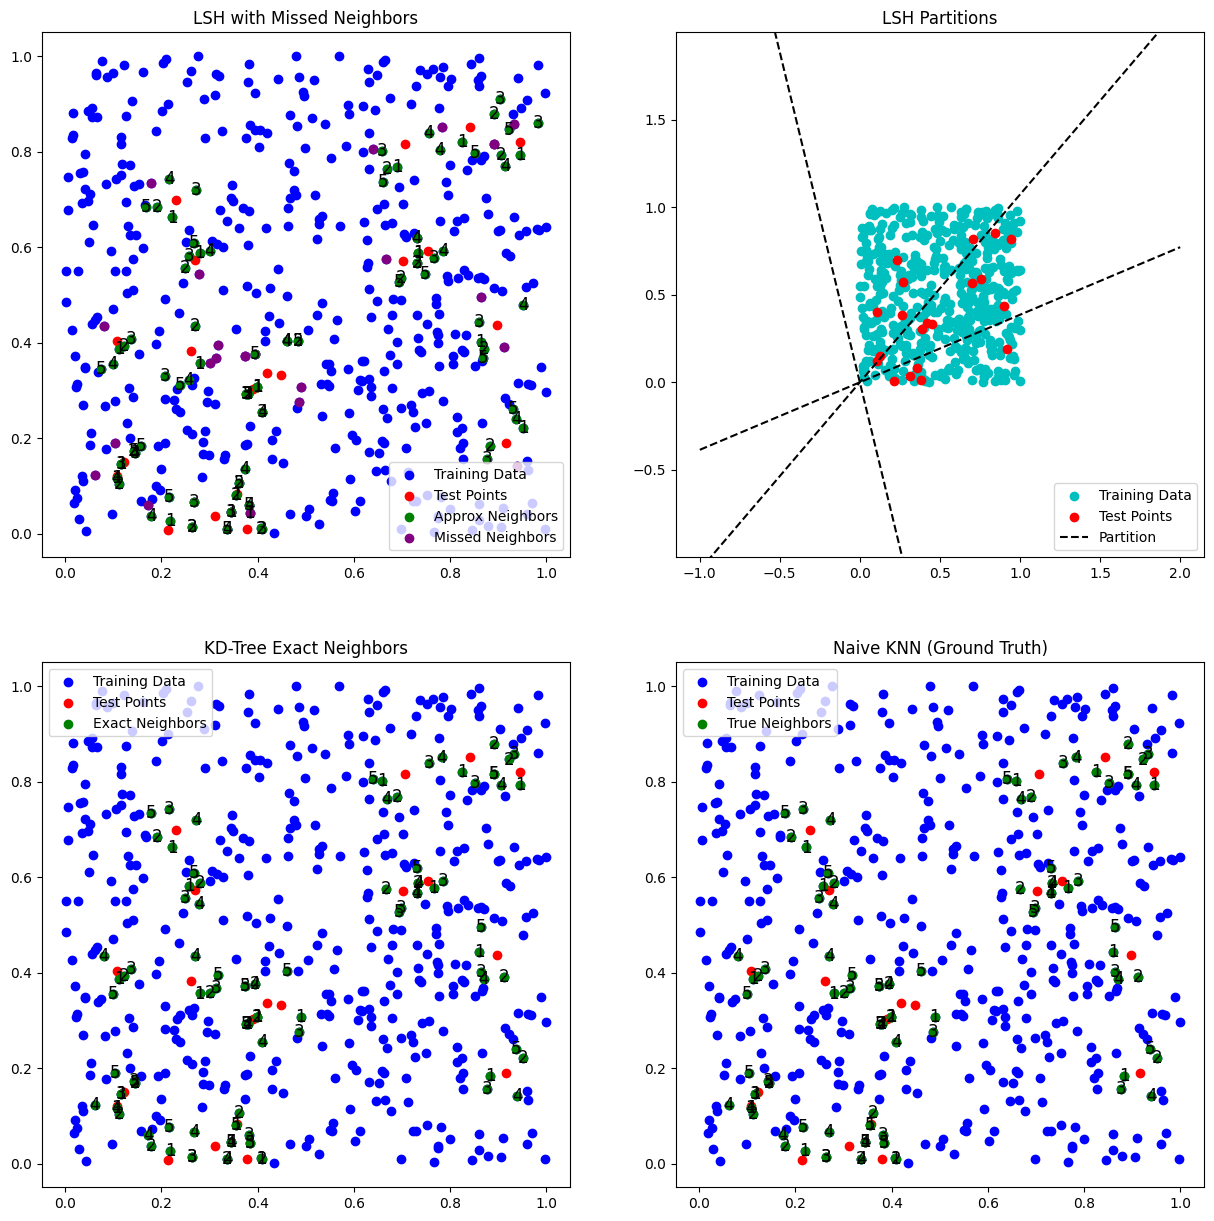

Total Missed Neighbors by Approximate KNN: 28


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.metrics import pairwise_distances
np.random.seed(20)

# 1. Implement Approximate KNN using LSH
def approximate_knn(X_train, X_test, K, projections=3):
    np.random.seed(25)
    R = np.random.randn(X_train.shape[1], projections)  # LSH random projection matrix
    X_train_proj = X_train @ R
    X_test_proj = X_test @ R
    nn = NearestNeighbors(n_neighbors=K, algorithm='brute').fit(X_train_proj)
    distances, indices = nn.kneighbors(X_test_proj)
    return indices, distances, R  # Return R as the LSH partition matrix

# 2. Implement KD-tree KNN
def kd_tree_knn(X_train, X_test, K):
    kd_tree = KDTree(X_train, leaf_size=30)
    distances, indices = kd_tree.query(X_test, k=K)
    return indices, distances

# 3. Implement Naive KNN
def naive_knn(X_train, X_test, K):
    distances = pairwise_distances(X_test, X_train)
    indices = np.argsort(distances, axis=1)[:, :K]
    k_distances = np.take_along_axis(distances, indices, axis=1)
    return indices, k_distances

# 4. Visualization of Missed Neighbors and Partitions in 2D Space
def visualize_knn_2d(X_train, X_test, K, W):
    indices_approx, _, _ = approximate_knn(X_train, X_test, K)  # Unpack the first two outputs
    indices_kd, _ = kd_tree_knn(X_train, X_test, K)
    indices_naive, _ = naive_knn(X_train, X_test, K)

    plt.figure(figsize=(15, 15))

    missed_neighbors_count = 0

    # Plotting Approximate KNN Results with Missed Neighbors Highlighted
    plt.subplot(2, 2, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label="Training Data")
    plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label="Test Points")
    
    for idx, test_pt in enumerate(X_test):
        neighbors = X_train[indices_approx[idx]]
        true_neighbors = X_train[indices_naive[idx]]
        
        plt.scatter(neighbors[:, 0], neighbors[:, 1], color='green', label="Approx Neighbors" if idx == 0 else "")
        
        missed_neighbors = [point for point in true_neighbors if point.tolist() not in neighbors.tolist()]
        if missed_neighbors:
            missed_neighbors = np.array(missed_neighbors)
            plt.scatter(missed_neighbors[:, 0], missed_neighbors[:, 1], color='purple', label="Missed Neighbors" if idx == 0 else "")
        missed_neighbors_count += len(missed_neighbors)
        # Label each of the nearest neighbors for the current test point
        for i, neighbor in enumerate(neighbors):
            plt.text(neighbor[0], neighbor[1], f"{i+1}", fontsize=12, color='black', ha='center', va='center')

    plt.title("LSH with Missed Neighbors")
    plt.legend()

    # Plotting LSH Partitions
    plt.subplot(2, 2, 2)
    plt.scatter(X_train[:, 0], X_train[:, 1], color='c', label="Training Data")
    plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label="Test Points")

    # Add LSH partitions as lines
    x_range = np.linspace(X_train[:, 0].min()-1, X_train[:, 0].max()+1, 500)
    for i in range(W.shape[1]):
        slope = -W[0, i] / W[1, i]  # Fixed slope calculation for 2D data
        intercept = 0  # The LSH hyperplanes pass through the origin
        y_range = slope * x_range + intercept
        plt.plot(x_range, y_range, linestyle="--", color="black", label="Partition" if i == 0 else "")

    plt.title("LSH Partitions")
    plt.ylim(X_train[:, 1].min()-1, X_train[:, 1].max()+1)
    plt.legend()

    # Plotting KD-Tree Results
    plt.subplot(2, 2, 3)
    plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label="Training Data")
    plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label="Test Points")
    
    for idx, test_pt in enumerate(X_test):
        neighbors = X_train[indices_kd[idx]]
        plt.scatter(neighbors[:, 0], neighbors[:, 1], color='green', label="Exact Neighbors" if idx == 0 else "")
        
        # Label each of the nearest neighbors for the current test point
        for i, neighbor in enumerate(neighbors):
            plt.text(neighbor[0], neighbor[1], f"{i+1}", fontsize=12, color='black', ha='center', va='center')

    plt.title("KD-Tree Exact Neighbors")
    plt.legend()

    # Plotting Naive KNN Results (Ground Truth)
    plt.subplot(2, 2, 4)
    plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label="Training Data")
    plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label="Test Points")
    
    for idx, test_pt in enumerate(X_test):
        neighbors = X_train[indices_naive[idx]]
        plt.scatter(neighbors[:, 0], neighbors[:, 1], color='green', label="True Neighbors" if idx == 0 else "")
        
        # Label each of the nearest neighbors for the current test point
        for i, neighbor in enumerate(neighbors):
            plt.text(neighbor[0], neighbor[1], f"{i+1}", fontsize=12, color='black', ha='center', va='center')

    plt.title("Naive KNN (Ground Truth)")
    plt.legend()

    plt.show()
    print(f"Total Missed Neighbors by Approximate KNN: {missed_neighbors_count}")
    
# Main Execution
if __name__ == "__main__":
    X_train = np.random.rand(500, 2)  # Training data in 2D
    X_test = np.random.rand(20, 2)    # Test data in 2D
    K = 5

    # Get LSH partition matrix
    _, _, W = approximate_knn(X_train, X_test, K)

    # Visualize KNN and LSH Partitions
    visualize_knn_2d(X_train, X_test, K, W)


# Including Intercept/Bias in the hyperplane equation:

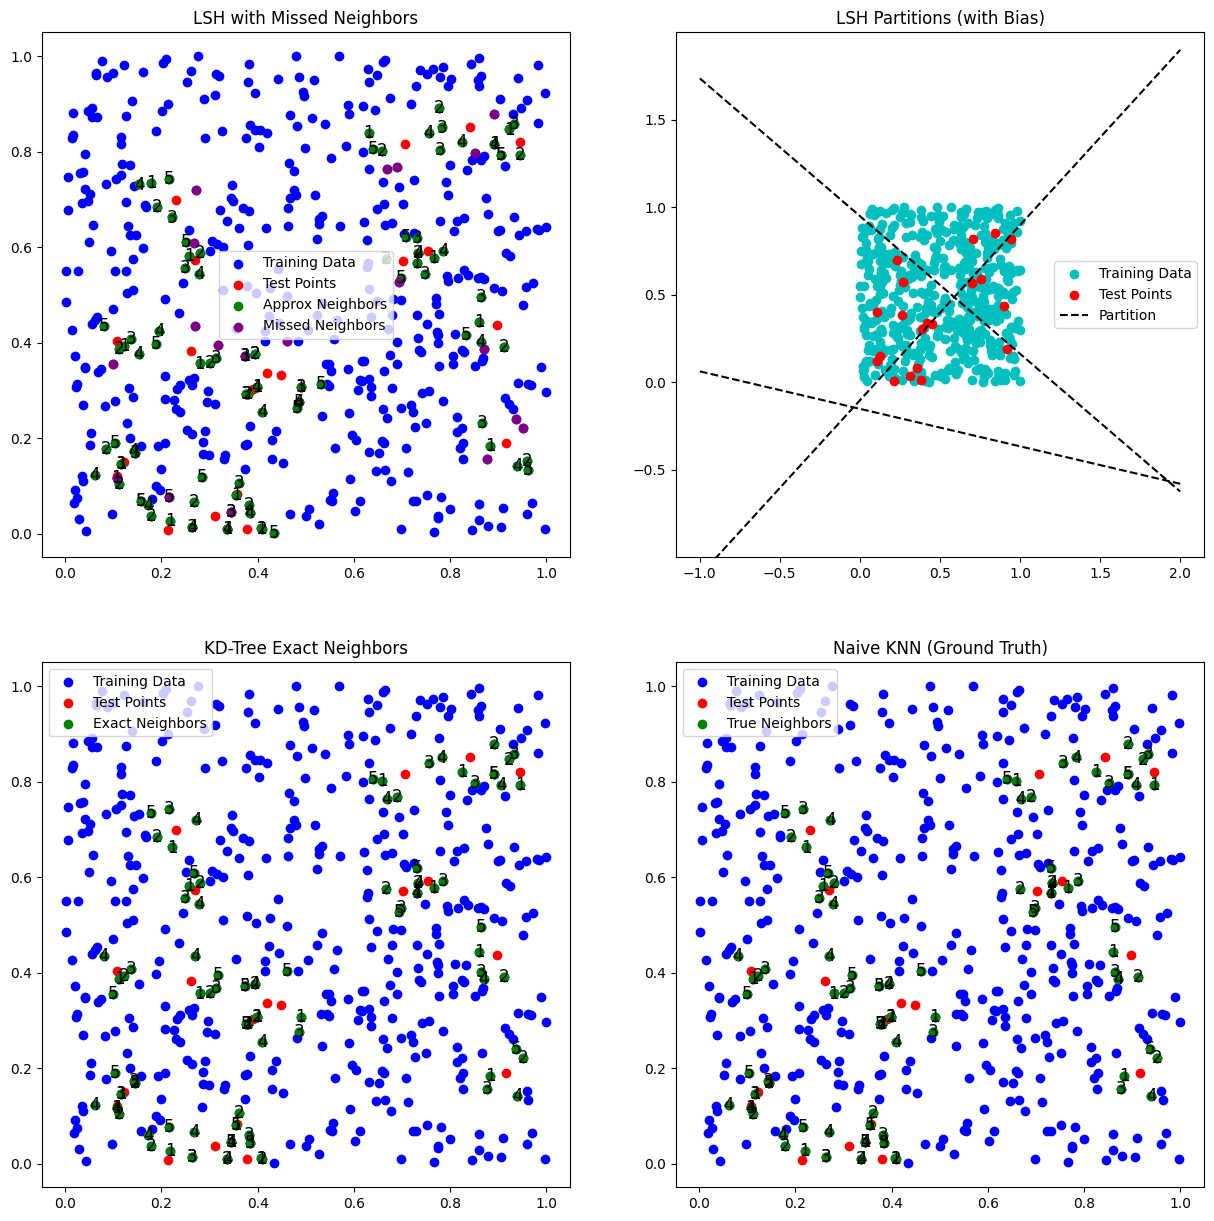

Total Missed Neighbors by Approximate KNN: 26


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.metrics import pairwise_distances
np.random.seed(20)

# 1. Implement Approximate KNN using LSH with bias (hyperplanes don't pass through origin)
def approximate_knn(X_train, X_test, K, projections=3):
    np.random.seed(0)
    # LSH random projection matrix and bias vector
    R = np.random.randn(X_train.shape[1], projections)  # Random projection matrix (no bias)
    b = np.random.randn(projections)  # Bias vector for each hyperplane
    
    # Project the training and test data
    X_train_proj = X_train @ R + b  # Add bias to projection
    X_test_proj = X_test @ R + b    # Add bias to projection
    
    nn = NearestNeighbors(n_neighbors=K, algorithm='brute').fit(X_train_proj)
    distances, indices = nn.kneighbors(X_test_proj)
    return indices, distances, R, b  # Return R and b as the LSH partition matrices

# 2. Implement KD-tree KNN
def kd_tree_knn(X_train, X_test, K):
    kd_tree = KDTree(X_train, leaf_size=30)
    distances, indices = kd_tree.query(X_test, k=K)
    return indices, distances

# 3. Implement Naive KNN
def naive_knn(X_train, X_test, K):
    distances = pairwise_distances(X_test, X_train)
    indices = np.argsort(distances, axis=1)[:, :K]
    k_distances = np.take_along_axis(distances, indices, axis=1)
    return indices, k_distances

# 4. Visualization of Missed Neighbors and Partitions in 2D Space
def visualize_knn_2d(X_train, X_test, K, R, b):
    indices_approx, _, _, _ = approximate_knn(X_train, X_test, K)  # Unpack the first two outputs
    indices_kd, _ = kd_tree_knn(X_train, X_test, K)
    indices_naive, _ = naive_knn(X_train, X_test, K)

    plt.figure(figsize=(15, 15))

    missed_neighbors_count = 0

    # Plotting Approximate KNN Results with Missed Neighbors Highlighted
    plt.subplot(2, 2, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label="Training Data")
    plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label="Test Points")
    
    for idx, test_pt in enumerate(X_test):
        neighbors = X_train[indices_approx[idx]]
        true_neighbors = X_train[indices_naive[idx]]
        
        plt.scatter(neighbors[:, 0], neighbors[:, 1], color='green', label="Approx Neighbors" if idx == 0 else "")
        
        missed_neighbors = [point for point in true_neighbors if point.tolist() not in neighbors.tolist()]
        if missed_neighbors:
            missed_neighbors = np.array(missed_neighbors)
            plt.scatter(missed_neighbors[:, 0], missed_neighbors[:, 1], color='purple', label="Missed Neighbors" if idx == 0 else "")
        missed_neighbors_count += len(missed_neighbors)
        # Label each of the nearest neighbors for the current test point
        for i, neighbor in enumerate(neighbors):
            plt.text(neighbor[0], neighbor[1], f"{i+1}", fontsize=12, color='black', ha='center', va='center')

    plt.title("LSH with Missed Neighbors")
    plt.legend()

    # Plotting LSH Partitions
    plt.subplot(2, 2, 2)
    plt.scatter(X_train[:, 0], X_train[:, 1], color='c', label="Training Data")
    plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label="Test Points")

    # Add LSH partitions as lines
    x_range = np.linspace(X_train[:, 0].min()-1, X_train[:, 0].max()+1, 500)
    for i in range(R.shape[1]):  # Iterate over the number of projections
        slope = -R[0, i] / R[1, i]  # Fixed slope calculation for 2D data
        intercept = b[i]  # The bias term (intercept) for each hyperplane
        y_range = slope * x_range + intercept
        plt.plot(x_range, y_range, linestyle="--", color="black", label="Partition" if i == 0 else "")

    plt.title("LSH Partitions (with Bias)")
    plt.ylim(X_train[:, 1].min()-1, X_train[:, 1].max()+1)
    plt.legend()

    # Plotting KD-Tree Results
    plt.subplot(2, 2, 3)
    plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label="Training Data")
    plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label="Test Points")
    
    for idx, test_pt in enumerate(X_test):
        neighbors = X_train[indices_kd[idx]]
        plt.scatter(neighbors[:, 0], neighbors[:, 1], color='green', label="Exact Neighbors" if idx == 0 else "")
        
        # Label each of the nearest neighbors for the current test point
        for i, neighbor in enumerate(neighbors):
            plt.text(neighbor[0], neighbor[1], f"{i+1}", fontsize=12, color='black', ha='center', va='center')

    plt.title("KD-Tree Exact Neighbors")
    plt.legend()

    # Plotting Naive KNN Results (Ground Truth)
    plt.subplot(2, 2, 4)
    plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label="Training Data")
    plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label="Test Points")
    
    for idx, test_pt in enumerate(X_test):
        neighbors = X_train[indices_naive[idx]]
        plt.scatter(neighbors[:, 0], neighbors[:, 1], color='green', label="True Neighbors" if idx == 0 else "")
        
        # Label each of the nearest neighbors for the current test point
        for i, neighbor in enumerate(neighbors):
            plt.text(neighbor[0], neighbor[1], f"{i+1}", fontsize=12, color='black', ha='center', va='center')

    plt.title("Naive KNN (Ground Truth)")
    plt.legend()

    plt.show()
    print(f"Total Missed Neighbors by Approximate KNN: {missed_neighbors_count}")
    
# Main Execution
if __name__ == "__main__":
    X_train = np.random.rand(500, 2)  # Training data in 2D
    X_test = np.random.rand(20, 2)    # Test data in 2D
    K = 5

    # Get LSH partition matrix with bias
    _, _, R, b = approximate_knn(X_train, X_test, K)

    # Visualize KNN and LSH Partitions
    visualize_knn_2d(X_train, X_test, K, R, b)


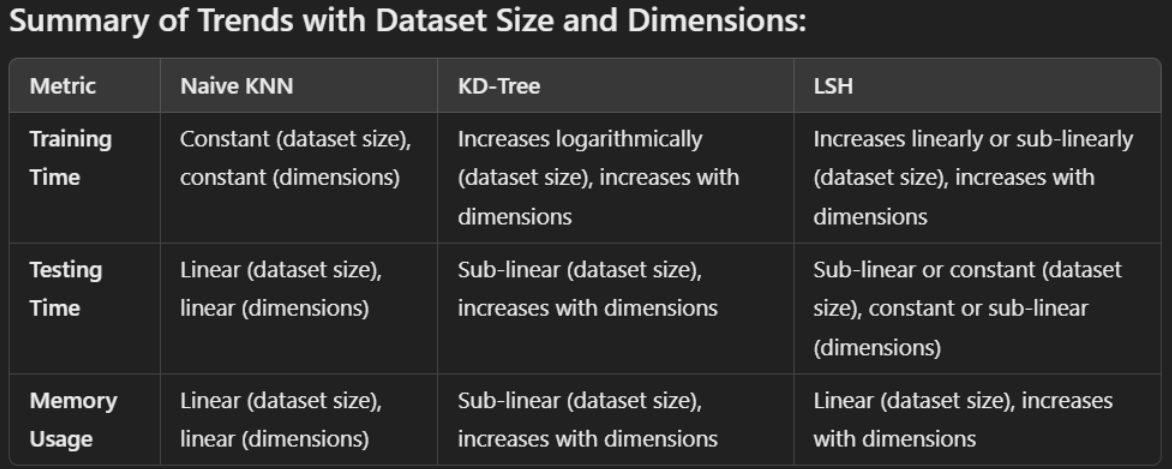